In [5]:
%pylab inline
import time
%load_ext Cython

Populating the interactive namespace from numpy and matplotlib
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [6]:
%%cython -a
import cython

cdef double G = 9.8
#cdef int N    = 200
cdef enum:
    N = 100



@cython.boundscheck(False)
cdef double sigma1 (double f0,double f1, double f2):
    return 3.3333333333333333333333333333333333*f0*f0 -  \
           10.333333333333333333333333333333333*f0*f1 +  \
           3.6666666666666666666666666666666667*f0*f2 +  \
           8.3333333333333333333333333333333333*f1*f1 -  \
           6.3333333333333333333333333333333333*f1*f2 +  \
           1.3333333333333333333333333333333333*f2*f2
            
@cython.boundscheck(False)            
cdef double sigma2 (double f0,double f1,double fm1):
    return 4.3333333333333333333333333333333333*f0*f0   -  \
           4.3333333333333333333333333333333333*f0*f1   -  \
           4.3333333333333333333333333333333333*f0*fm1  +  \
           1.3333333333333333333333333333333333*f1*f1   +  \
           1.6666666666666666666666666666666667*f1*fm1  +  \
           1.3333333333333333333333333333333333*fm1*fm1 
            
@cython.boundscheck(False)            
cdef double sigma3 (double f0,double fm1,double fm2):
    return 3.3333333333333333333333333333333333*f0*f0   - \
           10.333333333333333333333333333333333*f0*fm1  + \
           3.6666666666666666666666666666666667*f0*fm2  + \
           8.3333333333333333333333333333333333*fm1*fm1 - \
           6.3333333333333333333333333333333333*fm1*fm2 + \
           1.3333333333333333333333333333333333*fm2*fm2
            
@cython.boundscheck(False)            
cdef double fluxh (double h,double u,double zb,double alpha):
    return (h*u + alpha*(h+zb))/2.
@cython.boundscheck(False) 
cdef double fluxu (double h,double u,double zb,double alpha):
    return (h*u*u+0.5*G*(h*h-zb*zb) + alpha*(h*u))/2.


@cython.boundscheck(False)
cdef double weno5(double [:] hdum,double [:] udum,double [:] zdum, double [:] *flux_ct):
    cdef double fluxh_m[6]; 
    cdef double fluxh_p[6];  
    cdef double fluxu_m[6]; 
    cdef double fluxu_p[6]; 
    cdef double zb_half[6];
    cdef double alpha
   

    cdef int ic = 2
    cdef int i
    
    alpha = (udum[ic]*udum[ic])**0.5+(G*hdum[ic])**0.5

   
    for i in range(6):
        fluxh_m[i] = fluxh (hdum[i],udum[i],zdum[i],-alpha)
        fluxu_m[i] = fluxu (hdum[i],udum[i],zdum[i],-alpha)
        fluxh_p[i] = fluxh (hdum[i],udum[i],zdum[i],+alpha)
        fluxu_p[i] = fluxu (hdum[i],udum[i],zdum[i],+alpha)
        zb_half[i] = zdum[i]/2.0
  

        
    cdef double WD1 = 0.1
    cdef double WD2 = 0.6
    cdef double WD3 = 0.3
    cdef double eps   = 10.e-10
    
    cdef double IS1  = sigma1(fluxu_p[ic],fluxu_p[ic-1],fluxu_p[ic-2])
    cdef double IS2  = sigma2(fluxu_p[ic],fluxu_p[ic+1],fluxu_p[ic-1])
    cdef double IS3  = sigma3(fluxu_p[ic],fluxu_p[ic+1],fluxu_p[ic+2])

    
   
    cdef double WCL1 = WD1 / (eps+IS1)**2
    cdef double WCL2 = WD2 / (eps+IS2)**2
    cdef double WCL3 = WD3 / (eps+IS3)**2
    cdef double WCTL = WCL1 + WCL2 + WCL3
    
    ic = ic + 1
    
    IS1  =  sigma1(fluxu_m[ic],fluxu_m[ic-1],fluxu_m[ic-2])
    IS2  =  sigma2(fluxu_m[ic],fluxu_m[ic+1],fluxu_m[ic-1])
    IS3  =  sigma3(fluxu_m[ic],fluxu_m[ic+1],fluxu_m[ic+2])

    cdef double WCR3 = WD1 / (eps+IS1)**2
    cdef double WCR2 = WD2 / (eps+IS2)**2
    cdef double WCR1 = WD3 / (eps+IS3)**2
    cdef double WCTR = WCR1 + WCR2 + WCR3

    cdef double FL1, FL2, FL3, fluxL
    cdef double FR1, FR2, FR3, fluxR
    
    
  
    
    #cdef double  flux_CTL[3]
    #cdef double  flux_CTR[3]
    cdef double flux_p[6]
    cdef double flux_m[6]
    cdef double flux_CT[3]

    for i in range(3):
        flux_p = fluxh_p
        flux_m = fluxh_m
        if i==1:
            flux_p = fluxu_p
            flux_m = fluxu_m
        if i==2:
            flux_p = zb_half
            flux_m = zb_half
            
           
        
        FL1 = ( 2.0 * flux_p[0] - 7.0 * flux_p[1] + 11.0* flux_p[2] ) / 6.0
        FL2 = (     - flux_p[1] + 5.0 * flux_p[2] + 2.0 * flux_p[3] ) / 6.0
        FL3 = ( 2.0 * flux_p[2] + 5.0 * flux_p[3] -       flux_p[4] ) / 6.0
        fluxL = (WCL1 * FL1 + WCL2 * FL2 + WCL3 * FL3) / WCTL 

       
        FR1 = ( 2.0 * flux_m[5] - 7.0 * flux_m[4]  +11.0 * flux_m[3]  ) / 6.0
        FR2 = (     - flux_m[4] + 5.0 * flux_m[3]  + 2.0 * flux_m[2]  ) / 6.0
        FR3 = ( 2.0 * flux_m[3] + 5.0 * flux_m[2]  -       flux_m[1]  ) / 6.0        
        fluxR = (WCR1 * FR1 + WCR2 * FR2 + WCR3 * FR3) / WCTR
        flux_CT[i] = fluxL + fluxR
             
    #return flux_CT     

    

"""

@cython.boundscheck(False)
cdef double[:,:] rescalc(double [N+2*3] h,double [N+2*3] u,double [N+2*3] zb,double dx): 
#

    cdef int i
    #cdef double fluxhh[N+1]
    #cdef double fluxuu[N+1]
    #cdef double fluxbb[N+1]
    #cdef double Res[N][2]
    cdef double flux_cc[3]

# 
#
    for i in range(N+1):
#        for j in range(3):
            weno5(h[i:i+6],u[i:i+6],zb[i:i+6],double * flux_ct[:])
#        flux_cc = weno5(h[i:i+6],u[i:i+6],zb[i:i+6])
#         weno5(h[i:i+6],u[i:i+6],zb[i:i+6],*flux_cc[0:3])
        #fluxuu[i] = 0.0#flux_cc[1] 
        #fluxbb[i] = 0.0#flux_cc[2]

   
#    for i in range(N+2):
#        weno5(h[i:i+5],u[i:i+5],zb[i:i+5], flux_CTL, flux_CTR)
#        fluxhh[i][0] = flux_CTL[0]
#        fluxhh[i][1] = flux_CTR[0]
#        fluxuu[i][0] = flux_CTL[1]
#        fluxuu[i][1] = flux_CTR[1]
#        fluxbb[i][0] = flux_CTL[2]
#        fluxbb[i][1] = flux_CTR[2]
#
#    for i in range(N):
#        Res[i][0] = -(   fluxhh[i+1][0]+fluxhh[i+2][1]-fluxhh[i][0]-fluxhh[i+1][1] )/dx
#        Res[i][1] = -(  (fluxuu[i+1][0]+fluxuu[i+2][1]-fluxuu[i][0]-fluxuu[i+1][1]) +  \
#                        (fluxbb[i+1][0]+fluxbb[i+2][1]-fluxbb[i][0]-fluxbb[i+1][1])*G*(zb[i]+h[i]) )/dx
#    return Res

#cdef void bc():
#    for i in range(3):
#        h[i] = h[3]
#        u[i] = u[3]
#        h[N+2*NG-1-i] = h[N+2]
#        u[N+2*NG-1-i] = u[N+2]


"""






In [7]:


G = 9.81
N       = 100; dt = 10.e-4; NG      = 3; xlength = 2.; bump    = 0.2; NF = N+1
dx      = xlength/N
x       = linspace(-2.5*dx, xlength+2.5*dx, N+2*NG)

zb    = -1. + array([0.25*(cos(10.*pi*(k-1.5))+1.) if k>1.4 and k<1.6 else 0. for k in x])
eta   = array([ bump if k>1.1 and k<1.2 else 0. for k in x])
h     = eta-zb
u     = zeros(len(x))

fluxhh = zeros(N+2); fluxuu = zeros(N+2); fluxbb = zeros(N+2)
Resh = zeros(N); Resu = zeros(N)


def rescalc():
    


    for i in range(N+1):
        fluxhh[i], fluxuu[i], fluxbb[i] = weno5(h[i:i+6],u[i:i+6],zb[i:i+6])

    for i in range(N):
        Resh[i] = -(   fluxhh[i+1]-fluxhh[i] )/dx
        Resu[i] = -(  (fluxuu[i+1]-fluxuu[i] ) + \
                      (fluxbb[i+1]-fluxbb[i])*G*(zb[i]+h[i]) )/dx
    return (Resh, Resu)

def bc():
    for i in range(3):
        h[i] = h[3]
        u[i] = u[3]
        h[N+2*NG-1-i] = h[N+2]
        u[N+2*NG-1-i] = u[N+2]

h_old = zeros(len(h)); u_old = zeros(len(u))
hu = zeros(len(h)); hu_old = zeros(len(h))



for i in range(int(0.2/dt)):
    
    h_old = h; u_old = u
    hu_old = h*u
    (Resh, Resu) = rescalc()
    for i in range(N):
        h [i+3] = h_old[i+3]  + Resh[i]*dt
        hu[i+3] = hu_old[i+3] + Resu[i]*dt
        
    u = hu/h
    #h = h_new; u = u_new
    bc()
'''    
    (Resh, Resu) = rescalc()
    for i in range(N):
        h[i+3]  = (3.0/4.0)*h_old[i+3]  + (1.0/4.0)*h[i+3]  + (1.0/4.0)*Resh[i]*dt
        hu[i+3] = (3.0/4.0)*hu_old[i+3] + (1.0/4.0)*hu[i+3] + (1.0/4.0)*Resu[i]*dt
        
    u = hu/h
    bc()

    (Resh, Resu) = rescalc()
    for i in range(N):
        h[i+3]  = (1.0/3.0)*h_old[i+3]  + (2.0/3.0)*h[i+3]  + (2.0/3.0)*Resh[i]*dt
        hu[i+3] = (1.0/3.0)*hu_old[i+3] + (2.0/3.0)*hu[i+3] + (2.0/3.0)*Resh[i]*dt
    u = hu/h
    bc()
    #h = h_new; u = u_new

 '''
    

plot(x, h+zb)
ylim(-0.2,0.3)
print dt*200

NameError: global name 'weno5' is not defined

(-0.05, 0.12)

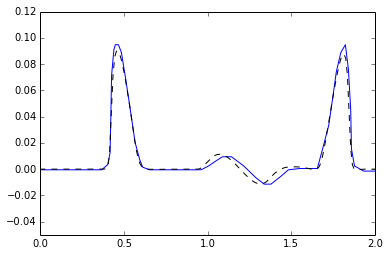

In [85]:
jcp_hplusb   = loadtxt("jcp_hplusb.txt")
plot(jcp_hplusb[:,0], jcp_hplusb[:,1]-1., 'b')
plot(x,h+zb,'k--')
xlim(0,2)
ylim(-0.05,0.12)

(-0.05, 0.12)

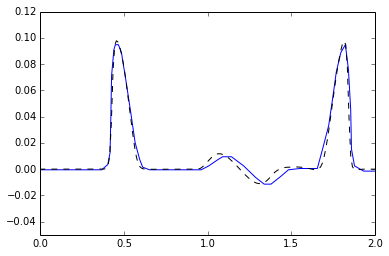